# An $F \rightarrow F+1$ MOT with small ground state g-factor

This example covers calculating the forces in a type-I, three-dimensional MOT
in a variety of different ways and comparing the various results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp

## Define the problem

We'll define the laser beams, magnetic field, and hamiltonian that we'll use:

In [2]:
# Laser beams parameters:
det = -1.5
alpha = 1.0
s = 1.0

# Define the laser beams:
laserBeams = pylcp.laserBeams(
    [{'kvec':np.array([1, 0, 0]), 's':s, 'pol':-1, 'delta':det},
     {'kvec':np.array([-1, 0, 0]), 's':s, 'pol':-1, 'delta':det}],
    beam_type=pylcp.infinitePlaneWaveBeam
)

# Actual linear gradient:
linGrad = pylcp.magField(lambda R: np.array([-alpha*R[0], np.zeros(R[1].shape),
                                             np.zeros(R[2].shape)]))

# Define the atomic Hamiltonian:
Fl = 1
Hg, muq_g = pylcp.hamiltonians.singleF(F=Fl, gF=0, muB=1)
He, muq_e = pylcp.hamiltonians.singleF(F=Fl+1, gF=1/(Fl+1), muB=1)

dijq =  pylcp.hamiltonians.dqij_two_bare_hyperfine(1, 2)

ham = pylcp.hamiltonian(Hg, He, muq_g, muq_e, dijq)

## Calculate equilibrium forces

We'll do this with two governing equations again, one `rateeq` and one `heuristiceq` for comparison.

In [3]:
rateeq = pylcp.rateeq(laserBeams, linGrad, ham, svd_eps=1e-10, include_mag_forces=False)
heuristiceq = pylcp.heuristiceq(laserBeams, linGrad)

Let now define a coordinate system over which to calculate and run both:

In [4]:
# Set up a coordinate system and laser parameters:
x = np.arange(-20+1e-9, 20.1, 0.5)
v = np.arange(-20, 20.1, 0.5)

X, V = np.meshgrid(x, v)

# Define the three-vectors used in the calculation:
Rvec = np.array([X, np.zeros(X.shape), np.zeros(X.shape)])
Vvec = np.array([V, np.zeros(V.shape), np.zeros(V.shape)])

heuristiceq.generate_force_profile(Rvec, Vvec, name='Fx')
rateeq.generate_force_profile(Rvec, Vvec, name='Fx', progress_bar=True,
                              default_axis=np.array([1., 0., 0.]))

Completed in 3.74 s.                                               


Plot up the resulting forces:

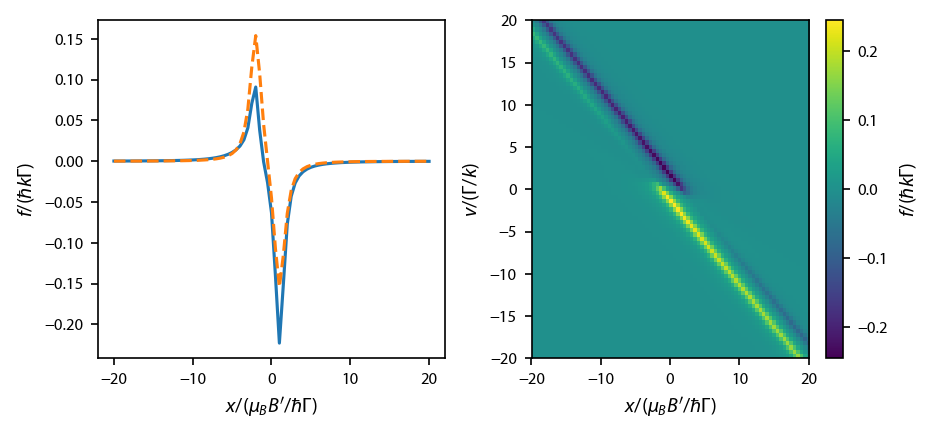

In [5]:
F0 = heuristiceq.profile['Fx'].F[0]
F2 = rateeq.profile['Fx'].F[0]

# Now plot it up:
fig, ax = plt.subplots(nrows=1, ncols=2, num="Force F=2->F=3", figsize=(6.5,2.75))
im1 = ax[1].imshow(F2,extent=(np.amin(X[0,:]), np.amax(X[0,:]),
                              np.amin(V[:,0]), np.amax(V[:,0])),
                   origin='bottom',
                   aspect='auto')
cb1 = plt.colorbar(im1)
cb1.set_label('$f/(\hbar k\Gamma)$')
ax[1].set_xlabel('$x/(\mu_B B\'/\hbar \Gamma)$')
ax[1].set_ylabel('$v/(\Gamma/k)$')

ax[0].plot(x, F2[int(np.ceil(F2.shape[0]/2)),:], '-', color='C0')
ax[0].plot(x, F0[int(np.ceil(F0.shape[0]/2)),:], '--', color='C1')
ax[0].set_ylabel('$f/(\hbar k \Gamma)$')
ax[0].set_xlabel('$x/(\mu_B B\'/\hbar \Gamma)$')

fig.subplots_adjust(wspace=0.25)

## Why is the oppositely directly force dissappearing at large magnetic field?

It turns out that we are getting an interesting effect when the non-cycling
transition from other beam starts to affect the population in the cycling
transition ground state.  Let's start by going figuring out the line to go along
for to stay in resonance with the rightward going beam.

Let's first look at this along lines that are going along $\hat{x}$ for various $v$:

In [ ]:
fig, ax = plt.figure(2, 1)


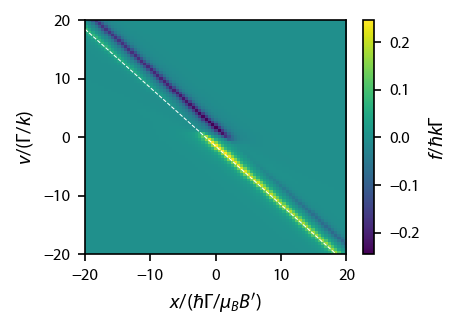

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.))
im1 = ax.imshow(F2,extent=(np.amin(X[0,:]), np.amax(X[0,:]),
                           np.amin(V[:,0]), np.amax(V[:,0])),
                   origin='bottom',
                   aspect='auto')
cb1 = plt.colorbar(im1, ax=ax)
ax.plot(x, det - alpha*x, 'w--', linewidth=0.5)
cb1.set_label('$f/\hbar k \Gamma$')
ax.set_xlabel('$x/(\hbar \Gamma/\mu_B B\')$')
ax.set_ylabel('$v/(\Gamma/k)$')
ax.set_ylim((np.amin(v), np.amax(v)))
fig.subplots_adjust(bottom=0.2, right=0.85)

Now, compute the parameters along that line: 

In [7]:
# Along the line v = delta - alpha x, we
v_path = det - alpha*x

rateeq.generate_force_profile([x, np.zeros(x.shape), np.zeros(x.shape)],
                              [v_path, np.zeros(x.shape), np.zeros(x.shape)],
                              name='res_path', default_axis=np.array([1., 0., 0.]))

Now, plot up the scattering rate and populations along that line:

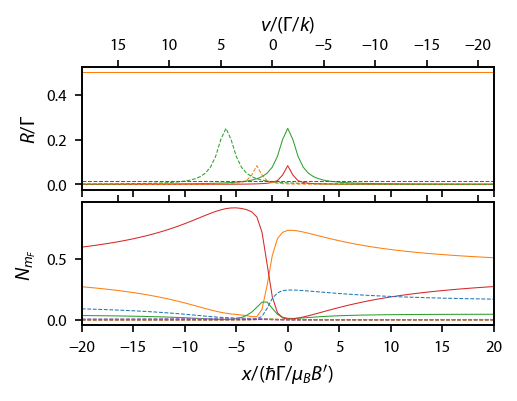

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(3.25, 2.5))

for ii in range(2*Fl+1):
    ax[0].plot(x, np.concatenate((rateeq.profile['res_path'].Rijl['g->e'][x<0, 0, ii, ii],
                                  rateeq.profile['res_path'].Rijl['g->e'][x>=0, 0, -1-ii, -1-ii])),
               color='C{0:d}'.format(ii+1), linewidth=0.5,
               label='$m_F= {0:d}\\rightarrow {1:d}$'.format(ii-1,ii-2))

for ii in range(2*Fl+1):
    ax[0].plot(x, np.concatenate((rateeq.profile['res_path'].Rijl['g->e'][x<0, 1, ii, ii+2],
                                  rateeq.profile['res_path'].Rijl['g->e'][x>=0, 1, -1-ii, -1-ii-2])),
               '--', color='C{0:d}'.format(ii+1), linewidth=0.5,
               label='$m_F= {0:d}\\rightarrow {1:d}$'.format(ii-1,ii))
    
for ii in range(2*Fl+1):
    ax[1].plot(x, np.concatenate((rateeq.profile['res_path'].Neq[x<0, ii],
                                 rateeq.profile['res_path'].Neq[x>=0, ham.ns[0]-ii-1])),
               color='C{0:d}'.format(ii+1), linewidth=0.5)

for ii in range(2*(Fl+1)+1):
    ax[1].plot(x, np.concatenate((rateeq.profile['res_path'].Neq[x<0, ham.ns[0]+ii],
                                  rateeq.profile['res_path'].Neq[x>=0, -1-ii])),
               '--', color='C{0:d}'.format(ii), linewidth=0.5)

[ax_i.set_xlim(-20, 20) for ax_i in ax];
ax_twin = [ax[ii].twiny() for ii in range(2)]
[ax_twin[ii].set_xlim(det - alpha*np.array(ax[ii].get_xlim())) for ii in range(2)];
ax_twin[1].xaxis.set_ticklabels('')
ax[0].xaxis.set_ticklabels('')
ax[1].set_xlabel('$x/(\hbar\Gamma/\mu_B B\')$')
ax_twin[0].set_xlabel('$v/(\Gamma/k)$')
ax[0].set_ylabel('$R/\Gamma$')
ax[1].set_ylabel('$N_{m_F}$')
fig.subplots_adjust(left=0.135, top=0.85)